# Lab: RNNs for Sentiment Analysis


------------------------------------------------------

*Pablo M. Olmos pamartin@ing.uc3m.es*


------------------------------------------------------

In this notebook we will deploy RNNs to perform sentiment analysis in a real dataset of finantial news. The required preprocesing using standard NLP libraries will be given to you (you have a course on NLP in the second term to learn this part) and your goal will be to define the RNN model, train it and validate the results.


We will use the [Finantial Phrase Bank](https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip), which contains  near 5000 sentences from finantial news:


>*This release of the financial phrase bank covers a collection of 4840 sentences. The selected collection of phrases was annotated by 16 people with adequate background knowledge on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.*
>
>*The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an economic or financial perspective are considered neutral.*

Lets load the database and preprocess it using [SpaCy](https://spacy.io/). This part is all given to you, so no need to worry much.




Completed by:

**Marina Gómez Rey (100472836)**

**María Ángeles Magro Garrote (100472867)**

**Ángela Durán Pinto (100472766)**

In [ ]:
# To use it in colab, update spacy
#!pip install --upgrade spacy

In [ ]:
# Download language model

!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
import spacy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
with open("Sentences.txt", "r", encoding="ISO-8859-1") as sentences:
    lines = sentences.readlines()

In lines, we have a list of sentences and an associted label, separated by the character `@`

In [ ]:
print(lines[0])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral



We split the sentence and we code with 0 neutral labels, with 1 negative labels, and with 2 positive labels

In [ ]:
phrases = [l.split('@')[0] for l in lines]
opinions = [l.split('@')[1] for l in lines]


def code_opinion(l):

    d = 0

    if (l=='negative\n'):

        d = 1

    elif (l=='positive\n'):

        d = 2

    return d

labels = np.array([code_opinion(l) for l in opinions])


In [ ]:
df = pd.DataFrame({"Phrase":phrases,
                  "Opinion":opinions})

df

,Phrase,Opinion
0,"According to Gran , the company has no plans t...",neutral\n
1,With the new production plant the company woul...,positive\n
2,"For the last quarter of 2010 , Componenta 's n...",positive\n
3,"In the third quarter of 2010 , net sales incre...",positive\n
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive\n
...,...,...
5712,Operating result for the 12-month period decre...,negative\n
5713,HELSINKI Thomson Financial - Shares in Cargote...,negative\n
5714,LONDON MarketWatch -- Share prices ended lower...,negative\n
5715,Operating profit fell to EUR 35.4 mn from EUR ...,negative\n


Lets plot the histogram of the labels ...

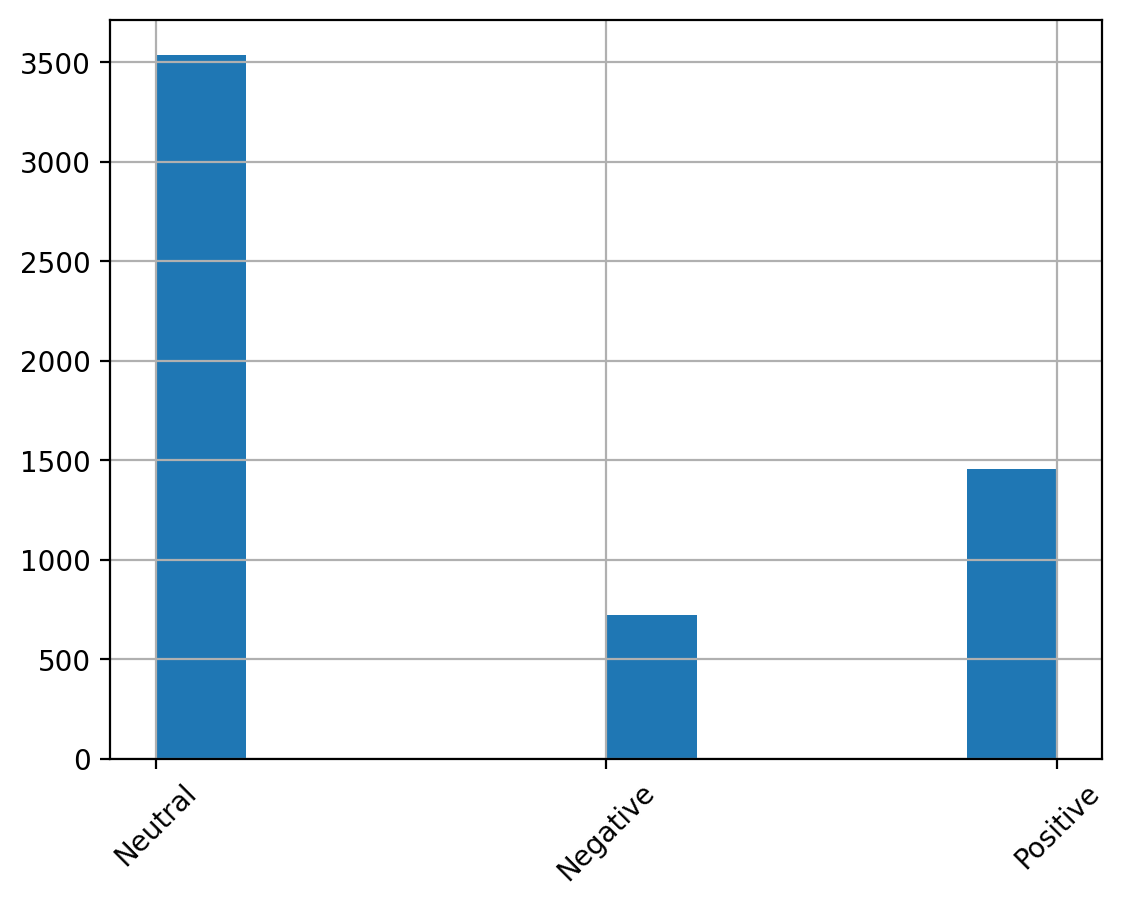

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(labels)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Neutral','Negative','Positive'],rotation=45)
ax.grid()


To simplify the problem, we're fusing together *Neutral* and *Positive* labels. So label 1 is *Negative review* and label 0 is *Positive+Neutral*. Also, we separate between train, validation and test.

In [ ]:
from sklearn.model_selection import train_test_split

labels_bin = labels.copy()

labels_bin[labels_bin==2] = 0

idx_data = np.arange(0,len(df),1)

# Separamos train de test
idx_train, idx_test, y_train, y_test = train_test_split(idx_data, labels_bin, test_size=0.2, random_state=0)

# Separamos train de val
idx_train, idx_val, y_train, y_val = train_test_split(idx_train, y_train, test_size=0.2, random_state=0)

acc_baseline_train = np.sum(y_train==0)/y_train.shape[0]

### Text pre-processing

With the following code, we pre-process using Spacy each sentence by removing words that are punctuation marks. We also remove [stopping words](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html) (words that are not very informative). As a result, we have the list `norm_docs`.

In [ ]:
nlp = spacy.load("en_core_web_md") # Language model


docs = [nlp(c) for c in phrases]

# We remove punctuation marks (.,;:?!...) and stopping words
def normalize(doc):

    return [w for w in doc if w.has_vector and not w.is_punct and not w.is_stop]

norm_docs = [normalize(d) for d in docs]

Every item of `norm_docs` corresponds to each of the sentences in the dataset. Each item is itself a list of spacy tokens (basically words with different attributes). The most important attribute for us the the *word embedding vector*. For instance, lets print the first sentence

In [ ]:
print(f'The first original sentence is: {phrases[0]}\n')

print(f'The first normalized sentence is: {norm_docs[0]}. The length of the document is {len(norm_docs[0])} tokens')

The first original sentence is: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

The first normalized sentence is: [According, Gran, company, plans, production, Russia, company, growing]. The length of the document is 8 tokens


We can access to the word embedding of each token using the attribute `.vector`:

In [ ]:
print(f'The word embedding associated with the token {norm_docs[0][0].text} is\n')
print(norm_docs[0][0].vector)

The word embedding associated with the token According is

[-7.2518e-01 -6.5831e+00  1.9781e+00  1.5750e+00  3.7848e+00 -7.7536e-01
  1.6243e+00  1.3813e+00 -7.4554e-01 -3.3811e+00  5.6047e-01  1.1629e+00
 -9.7465e-01  6.6956e-01  4.2558e-01  4.1766e+00  4.6478e+00  3.5616e+00
  7.3597e-01  3.6554e-01 -2.2610e+00 -4.1928e+00 -6.7455e-01  1.7693e+00
 -1.5665e-01 -1.1390e+00  1.8747e+00  2.9538e+00  5.5879e-01  3.0424e-01
  2.3027e-01  3.6405e-02  8.8395e-01  1.0494e+00 -1.7269e+00 -3.3406e-01
 -1.0464e+00 -9.8123e-01 -2.1267e+00 -2.9542e+00 -4.3075e+00 -1.5900e+00
 -8.9226e-01  3.6363e-01 -3.7703e+00 -1.8992e+00 -5.3433e-01  4.0256e+00
 -1.8628e+00 -1.9761e+00  1.2977e+00  3.6029e+00  1.6310e+00 -2.5195e+00
  2.0482e+00 -1.4805e+00 -1.4294e-01 -2.7591e+00 -3.4827e-01 -6.1484e+00
 -5.9045e-01 -5.3691e-01 -7.3631e-01  3.1585e+00  5.7914e+00 -1.1208e+00
 -2.5045e+00 -2.2957e+00  2.7173e+00  1.1104e+00  2.0943e+00 -2.6719e+00
 -2.6322e+00 -3.9377e+00 -1.3198e+00  3.5639e+00 -1.3974e+00  2.7

You can check that the word embedding dimension is 300 ...

In [ ]:
print(f'The WE dimension is {norm_docs[0][0].vector.shape}')

The WE dimension is (300,)


### Length normalization

Note that in this problem we're working with sequences of text of different length. This is in principle not a problem for RNNs. However, there's one additional pre-processing step that we have to do. When we feed the RNN function **all sequences in the mini-batch must have the same length**. Then we will use the corresponding state to make the prediction.

For simplicity, we are taking here a non-efficient solution. Instead of normalize lengths at a batch level, we are normalizing the whole dataset so all sequences have the same length. To do so, we're adding **junk tokens** to all sentences so they artificially are of the same length. However, we will keep in a list the real length of each data, since the sentiment analysis prediction will be made using the RNN state corresponding to the **last real token**.



In [ ]:
# List with the length for each sentence

lengths = [len(d) for d in norm_docs]

# Maximum length (in train!)
max_l = np.max([lengths[d] for d in idx_train])

In [ ]:
# We add as many junk tokens (#) as needed to equalize the length of each sentence to max_l

garbage_token = nlp('#') # Junk token --> #

# We normalize the dataset

norm_docs_eq_length = [norm_docs[d]+[garbage_token]*(max_l-lengths[d]) for d in range(len(norm_docs))]

# Train documents

docs_train = [norm_docs_eq_length[d] for d in idx_train]

len_train = [lengths[d] for d in idx_train]

# Validation documents

docs_val = [norm_docs_eq_length[d] for d in idx_val]

len_val = [lengths[d] for d in idx_val]

# documentos test

docs_test = [norm_docs_eq_length[d] for d in idx_test]

len_test = [lengths[d] for d in idx_test]

Recall that for each document, the sequence of word embeddings is obtained using the `.vector` attribute per token ...

### RNN classification

Our goal is to implement an LSTM that takes as input the sequence of word embeddings and predicts the binary label. In the list `lengths` we have the length per document (before adding the junk tokens). The LSTM prediction **must be done using the LSTM state after processing the last real token**. That means we ignore the LSTM states after we start processing the junk tokens.


A few comments:

- The LSTM is trained using mini-batches. So the input is a tensor of dimension (batch_size, seq_length, max_l). You have to generate this tensor using the lists implemented before (`docs_train`, `docs_val`, `docs_test`).
- You don't care about the LSTM initializaiton. Use the default one.
- The LSTM provides the list of states upon processing the sequences of max_l word embeddings. For each sentence, you have to predict the label using the appropiate state (the one after processing the last real word). My advise is that you store in a list the decision states for each data in the minibatch and then concatenate them in a tensor using `torch.stack`.
- We will use a single MLP layer to perform the prediction. Between the LSTM and the MLP, we include a dropout layer.
- The network will take some time to train, so my advise is to save the network parameters after each epoch (in a separate file), so early stopping can be implemented without re-training.
- Validate the dimension of the LSTM state.

<img src='http://www.tsc.uc3m.es/~olmos/BBVA/RNN.png' width=800 />




In [ ]:
from torch import nn
from torch import optim
import torch

>**Exercise:** Complete the following code to construct the RNN classifier

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,prob=0.5):


        super().__init__()

        self.hidden_dim = hidden_dim

        self.input_size = input_size

        # LSTM layer

        # Define an LSTM (Long Short-Term Memory) neural network layer with:
        # input_size: The number of expected features in the input x
        # hidden_dim: The number of features in the hidden state h
        # n_layers: Number of recurrent layers
        # dropout: If non-zero, introduces a dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to prob
        # batch_first: If True, then the input and output tensors are provided as (batch_size, sequence_length, feature_dim)

        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=1)

        # Capa dropout

        self.dropout = nn.Dropout(p=prob)

    def forward(self, x, lengths, h0=None):

        '''

        - x: Sequences of word embeddings. Dimensions (batch_size, max_l, word_embedding_size)
        - lengths: The real length of each sequence, excluding the junk # tokens! You use this to know what
          RNN state you should use to classify

        '''

        batch_size = x.size(0)
        seq_length = x.size(1)
        #print('seq_length', seq_length)

        # Compute the RNN output (sequence of states for the whole input)
        r_out, _ =  self.rnn(x, h0)
        #print('r_out', r_out)

        # Now it comes the tricky part. You have to stack in a (batch_size, hidden_dim) tensor, the right state
        # for each sequece. Namely, the state after processing the last real token (not the junk # ones)
        # The function torch.stack() can be handy
        #print('lengths',lengths)
        #print('range(batch_size)',range(batch_size))
        aux = torch.stack([r_out[[d],lengths[d]-1,:] for d in range(batch_size)]).reshape([-1,self.hidden_dim])
        #3print('aux', aux)
        # We classify using such tensor (don't forget the dropout!)

        #output = self.logsoftmax(#YOUR  CODE HERE)
        output = self.logsoftmax(self.fc1(self.dropout(aux)))
        #print('output',output)
        return output

Let's first illustrate how we can get the output of the (untrained) RNN network given our texts. For example, let's get the RNN output for the first three training texts. The first step is to get the **sequences of word embeddings** of each of them...

In [ ]:
idx = [1,2,3]

#[w.vector for w in docs_train[d]] generates the list of word vectors for the d-th document
x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])

<ipython-input-18-31b6a0fc2f9f>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx])


In [ ]:
d=1

np.array([docs_train[d][w].vector for w in range(len_train[d])]).shape

(14, 300)

In [ ]:
aux = torch.Tensor([np.mean([docs_train[d][w].vector for w in range(len_train[d])],0) for d in idx])

The shape of `x_input` should be (3,max_l,300)

In [ ]:
x_input.shape

torch.Size([3, 35, 300])

Let's instantiate the RNN class

In [ ]:
my_RNN = RNN(300,2,20,1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


> **Exercise:** evaluate the RNN otuput for `x_input` and check that the ouput dimensions make sense

In [ ]:
o = my_RNN.forward(x_input,[lengths[d] for d in idx])

In [ ]:
print(o)

tensor([[-0.6949, -0.6913],
        [-0.6388, -0.7507],
        [-0.4440, -1.0257]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
o.shape

torch.Size([3, 2])

> **Exercise:** Complete the following class, which inherits the previous one and it adds a training loop, an evaluation method, and functionalities to save the model every few epochs

In [ ]:
class RNN_with_train(RNN):

    def __init__(self,input_size, output_size, hidden_dim, n_layers,prob=0.0,batch_size=50,lr=0.0005,saved_files='./saved_models/RNN_sentiment_analysis'):

        super().__init__(input_size, output_size, hidden_dim, n_layers,prob)

        self.lr = lr # Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr) # Optimizer

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.batch_size = batch_size

        self.saved_files = saved_files


    def predict_proba(self,docs,lengths,Y=None):

        '''
        We use this method to get the output of the network given a set of documents. If label is provided,
        we get accuracy.

        - docs: documents, each encoded as a list of spacy tokens. They are length-normalized.
        - lengths: real length of each document.
        - Y: labels
        '''
        accuracy = 0.0

        with torch.no_grad():

            x_input = torch.Tensor([[w.vector for w in d] for d in docs])
            ####
            logprobs = self.forward(x_input,lengths).detach().numpy()

            if(len(Y)>0):

                accuracy = np.sum(np.argmax(logprobs,1)==Y)/np.shape(Y)[0]

        return logprobs,accuracy

    def fit(self,docs_train,docs_val,Y,Yval,len_train,len_val,epochs=100,print_every=5):

        '''
        Método de entrenamiento.

        - docs_train, docs_val: training/validation documents  (each is a list of spacy tokens).
          Normalized in length!
        - len_train/len_val: real lengths
        '''

        self.print_every = print_every

        self.epochs=epochs

        # Optimization Loop

        self.num_train = len(docs_train) # Number of training points

        self.num_batchs = np.floor(self.num_train/self.batch_size) # Number of training batches

        self.num_val = len(docs_val) # Number of validation points

        self.num_batchs_val = np.floor(self.num_val/self.batch_size) # Numero of validation batches

        labels = torch.Tensor(Y).type(torch.LongTensor) # Training labels

        labelsval = torch.Tensor(Yval).type(torch.LongTensor) # Validation labels


        for e in range(int(self.epochs)):

            self.train() # Activate dropout

            # Random data permutation

            idx = np.random.permutation(self.num_train)

            running_loss = 0.

            for i in range(int(self.num_batchs)):

                self.optim.zero_grad()

                # Indices of the data entering the batch

                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                # Just in case there are empty documents, we ignore them
                idx_batch = [d for d in idx_batch if len_train[d]>0]

                # We code each document using the sequences of word embeddings

                x_input = torch.Tensor([[w.vector for w in docs_train[d]] for d in idx_batch])

                # We compute the classifier output for every data

                out = self.forward(x_input,[len_train[d] for d in idx_batch])

                # Cost function and gradient descent step

                loss = self.criterion(out,labels[idx_batch])

                running_loss += loss.item()

                loss.backward()

                # Gradient clipping
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)

                # SGD steps

                self.optim.step()

            self.loss_during_training.append(running_loss/self.num_batchs)

            # We save model parameters

            torch.save(self.state_dict(), self.saved_files+'_epoch_'+str(e)+'.pth')

            # We repeat for validation

            with torch.no_grad():

                # set model to evaluation mode
                self.eval()

                running_loss = 0.

                idx = np.random.permutation(self.num_val)

                running_loss = 0.

                for i in range(int(self.num_batchs_val)):

                    idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                    # Just in case there are empty documents, we ignore them
                    idx_batch = [d for d in idx_batch if len_val[d]>0]

                    x_input = torch.Tensor([[w.vector for w in docs_val[d]] for d in idx_batch])

                    out = self.forward(x_input,[len_val[d] for d in idx_batch])

                    loss = self.criterion(out,labelsval[idx_batch])

                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/self.num_batchs_val)



            if(e % self.print_every == 0):

                print(f"Training loss after {e} epochs: {self.loss_during_training[-1]}. Validation loss: {self.valid_loss_during_training[-1]}")

> **Exercise:** Instantiate and train the class using a hidden state of 20 dimensions and dropout probability equal to 0.3. Train for 40 epochs (can take a while)

In [ ]:
my_RNN = RNN_with_train(300,2,20,1)

#Call train

# Fit the custom RNN model to the training data while validating on the validation data.
# Arguments:
# - docs_train: Training input data (documents)
# - docs_val: Validation input data (documents)
# - torch.Tensor(y_train): Training target data
# - torch.Tensor(y_val): Validation target data
# - len_train: Length of the training set
# - len_val: Length of the validation set
# - epochs: Number of training epochs -> we set 30 instead of 40 to avoid overfitting!!
# - print_every: Frequency of printing training progress

my_RNN.fit(docs_train,docs_val,torch.Tensor(y_train),torch.Tensor(y_val),len_train,len_val,epochs=30,print_every=1)

Training loss after 0 epochs: 0.49728035600218057. Validation loss: 0.3755524969763226
Training loss after 1 epochs: 0.36519615045965537. Validation loss: 0.3273269972867436
Training loss after 2 epochs: 0.3300971460260757. Validation loss: 0.31113819695181316
Training loss after 3 epochs: 0.30762073397636414. Validation loss: 0.2941211089491844
Training loss after 4 epochs: 0.28790485960979983. Validation loss: 0.2876507139040364
Training loss after 5 epochs: 0.2683618037055617. Validation loss: 0.2853920054104593
Training loss after 6 epochs: 0.25113379730753704. Validation loss: 0.27041782728499836
Training loss after 7 epochs: 0.23195969578746248. Validation loss: 0.26487553699149025
Training loss after 8 epochs: 0.21447352401606024. Validation loss: 0.2508259150716994
Training loss after 9 epochs: 0.19726738149989143. Validation loss: 0.25131502664751476
Training loss after 10 epochs: 0.18061896576865077. Validation loss: 0.2401244276099735
Training loss after 11 epochs: 0.1684403

> **Exercise:** Plot both validation and training loss. Recover the model parameters for the epoch that minimized the validation loss. To do so, note that at every epoch the model parameters are save in a certain file named  `RNN_sentiment_analysis_epoch_X.pth` (unless you changed the default value), where `X` is the epoch. The function to re-state the parameters of the network are  `state_dict = my_RNN.load_state_dict(torch.load('RNN_sentiment_analysis_epoch_X.pth'))
`

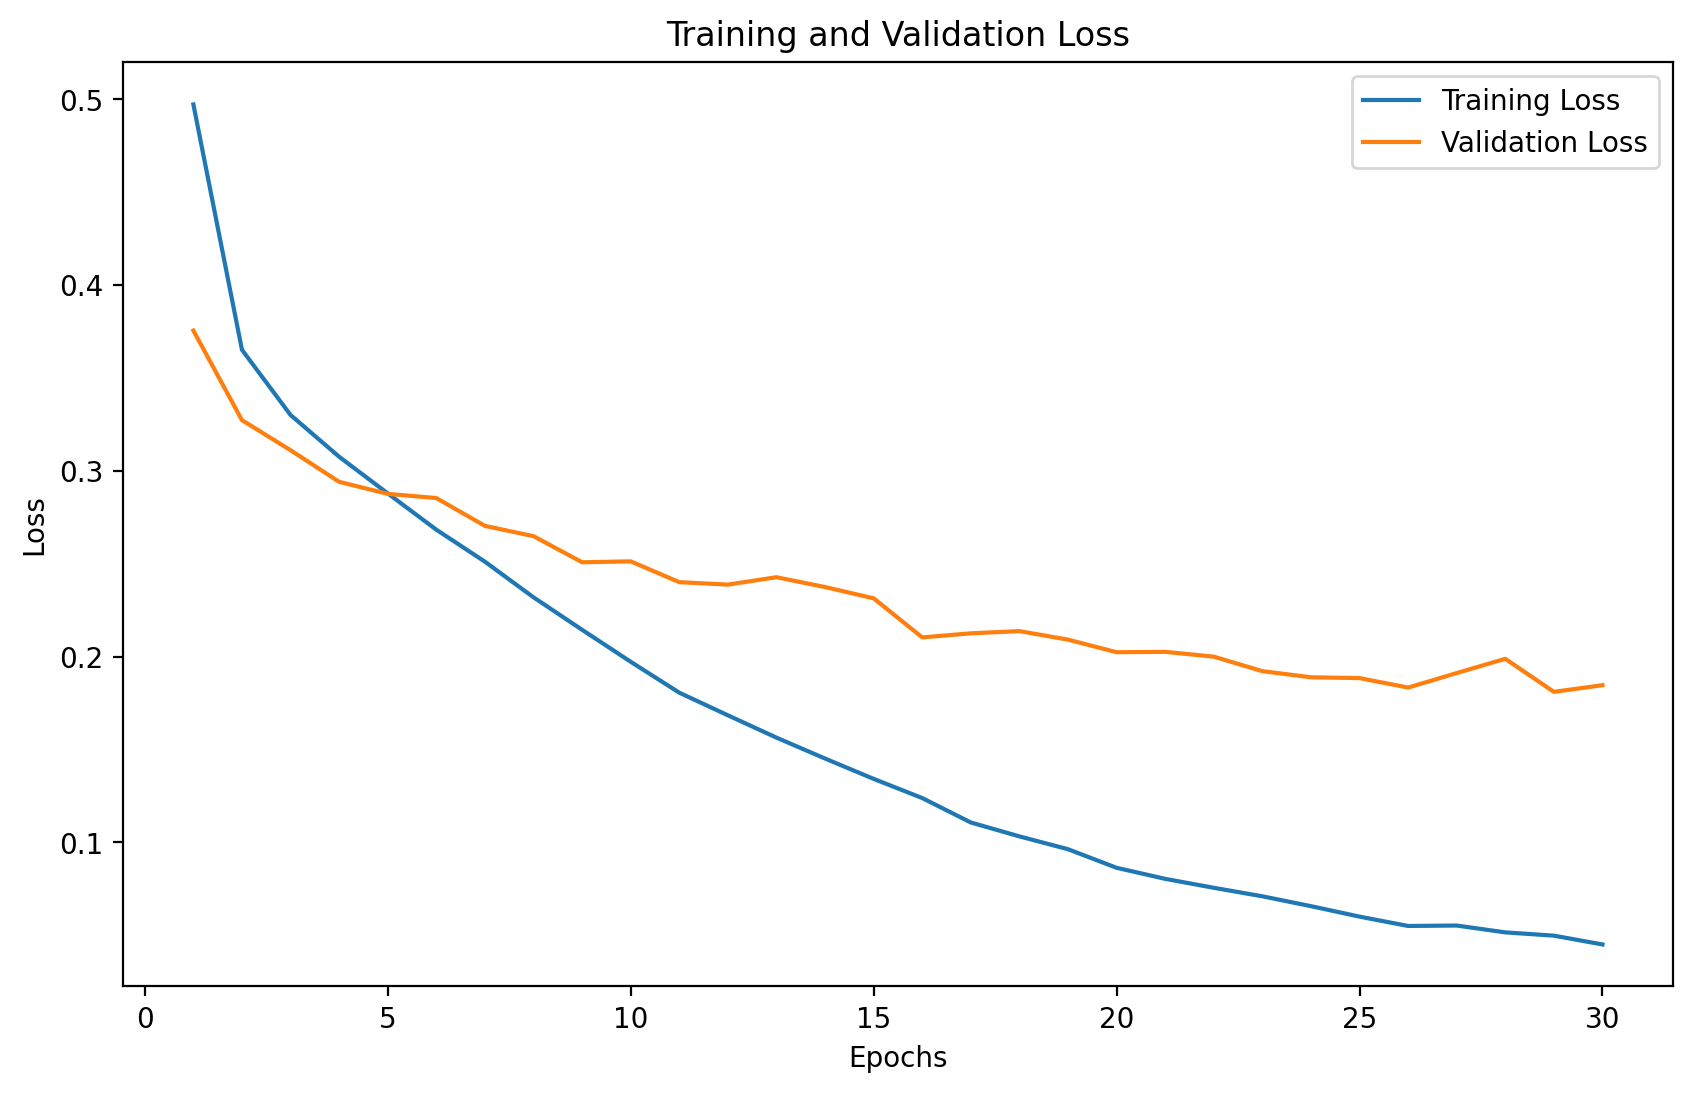

In [ ]:
# Plotting the train/val loss
plt.figure(figsize=(10, 6))
# Plotting the training loss over epochs
plt.plot(range(1, len(my_RNN.loss_during_training) + 1), my_RNN.loss_during_training, label='Training Loss')
# Plotting the validation loss over epochs
plt.plot(range(1, len(my_RNN.valid_loss_during_training) + 1), my_RNN.valid_loss_during_training, label='Validation Loss')
# Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Recovering the best validation parameters

# # Finding the indices of the sorted validation loss values in ascending order
idx_min = np.argsort(my_RNN.valid_loss_during_training)

my_RNN.load_state_dict(torch.load(my_RNN.saved_files+'_epoch_'+str(idx_min[0])+'.pth'))

<All keys matched successfully>

> **Exercise:** Using the method `predict_proba`, compute the accuracy and class probabilities for the data in the test set. Note that the method returns log-probabilities that you have to exponentiate.

In [ ]:
# Using the method predict_proba to compute the log-probabilities and accuracy for the data in the test set
logprobs,acc = my_RNN.predict_proba(docs_test,len_test,y_test)

# Converting the log-probabilities to probabilities by exponentiating them
probs = np.exp(logprobs)

print(f"The test accuracy is {acc}")

The test accuracy is 0.9475524475524476


The following code plots the ROC curve of the classifiers, and it computes the area under the curve:

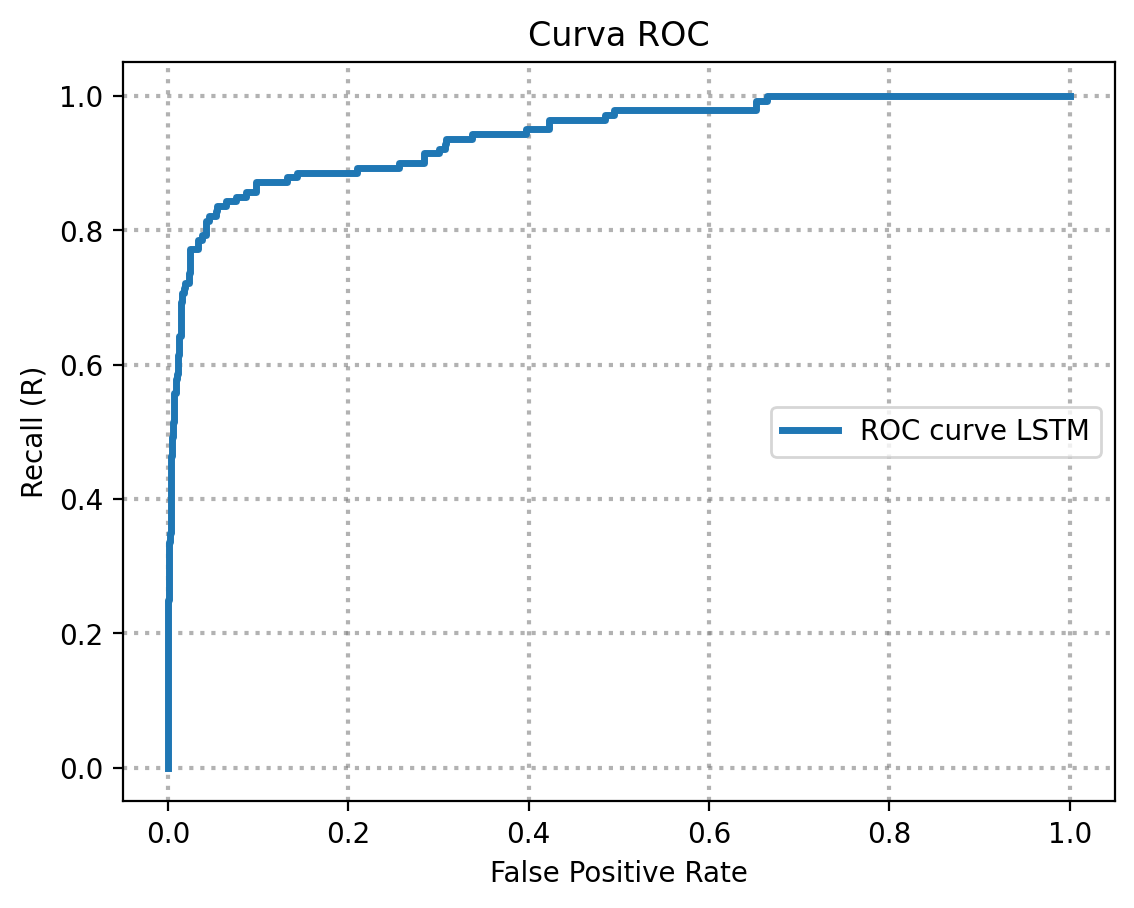

AUC ROC for LSTM is 0.9416974957313602


In [ ]:
from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='ROC curve LSTM')
plt.legend(loc=7)
plt.grid(True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
# this line was giving error because of b =
#plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc_LSTM = metrics.roc_auc_score(y_test, probs[:,1])

print(f"AUC ROC for LSTM is {area_roc_LSTM}")

If you do not implement the optimal part, just know that the proposed MLP solution AUC is typically less than 0.9

### (OPTIONAL)

Compare the accuracy/ROC with those achieved by the MLP classifier that predicts the label using the **mean of the word embeddings** (without junk tokens). Consider a three layer MLP with 10 and 5 hidden units respectively.


<img src='http://www.tsc.uc3m.es/~olmos/BBVA/MLP.png' width=800 />

We needed to check first how to select the indexes that were correct in order to exclude the junk items.

This lenghts were the original indexes that were stored in idx_train, validation and test set.

In [ ]:
# Select the lengths corresponding to training, validation, and test indices
train_lengths = [lengths[i] for i in idx_train]
val_lengths = [lengths[i] for i in idx_val]
test_lengths = [lengths[i] for i in idx_test]

# Verify the lengths
print("Training lengths:", train_lengths)
print("Validation lengths:", val_lengths)
print("Test lengths:", test_lengths)

Training lengths: [16, 14, 9, 11, 10, 3, 8, 14, 19, 7, 9, 9, 8, 12, 25, 16, 12, 5, 26, 10, 9, 20, 10, 6, 8, 17, 7, 9, 12, 16, 6, 8, 9, 10, 24, 5, 23, 18, 18, 5, 14, 5, 7, 24, 15, 18, 14, 2, 7, 15, 14, 9, 18, 15, 26, 13, 7, 11, 10, 9, 18, 10, 2, 8, 9, 11, 17, 18, 20, 13, 6, 12, 14, 13, 13, 12, 15, 14, 14, 5, 15, 10, 28, 14, 9, 17, 28, 14, 10, 12, 6, 8, 6, 17, 12, 10, 5, 10, 19, 10, 26, 17, 16, 19, 12, 5, 14, 11, 24, 7, 5, 11, 4, 16, 9, 12, 6, 8, 7, 9, 13, 9, 18, 7, 6, 12, 8, 24, 9, 24, 18, 18, 6, 12, 11, 16, 7, 6, 8, 18, 21, 10, 26, 12, 14, 28, 9, 5, 7, 14, 25, 11, 9, 8, 7, 6, 11, 25, 12, 9, 12, 9, 6, 10, 14, 9, 12, 10, 9, 6, 16, 10, 7, 23, 12, 10, 6, 12, 16, 12, 20, 8, 24, 14, 12, 15, 6, 3, 14, 17, 6, 13, 7, 12, 15, 10, 9, 14, 11, 12, 3, 5, 17, 11, 13, 16, 7, 10, 13, 3, 8, 4, 13, 12, 13, 23, 7, 6, 17, 7, 12, 3, 10, 9, 9, 10, 7, 15, 13, 5, 19, 9, 14, 7, 2, 17, 17, 18, 8, 16, 18, 10, 28, 16, 7, 9, 6, 11, 5, 12, 13, 10, 11, 15, 10, 11, 11, 2, 8, 19, 10, 8, 4, 26, 8, 5, 21, 9, 5, 8, 8, 17,

Remember, that after adding the "#", all the docs had the same lenght. **We should take the lenghts above mentioned!**

In [ ]:
# Calculate the lengths of documents in the training, validation and test set after adding junk tokens
train_lengths_with_junk = [len(doc) for doc in docs_train]
val_lengths_with_junk = [len(doc) for doc in docs_val]
test_lengths_with_junk = [len(doc) for doc in docs_test]

# Print the lengths of documents in the training, validation and test set after adding junk tokens
print("Lengths of documents in the training set after adding junk tokens:", train_lengths_with_junk)
print("Lengths of documents in the validation set after adding junk tokens:", val_lengths_with_junk)
print("Lengths of documents in the test set after adding junk tokens:", test_lengths_with_junk)

Lengths of documents in the training set after adding junk tokens: [35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 

First, we will define a function compute_mean_embedding() to compute the mean vector representation of each document, excluding junk tokens. It iterates over each token in a document **up to a specified length**, extracting their vector representations, and then calculates their mean.

Next, it applies this function to both the training and test datasets, generating mean embeddings for each document. The **correct lenghts are passed** as an input to compute_mean_embedding function.

These embeddings are then used as input features to train an MLP classifier with two hidden layers containing 10 and 5 units, respectively.

Finally, the MLPClassifier from scikit-learn is instantiated and trained on the mean embeddings of the training data.

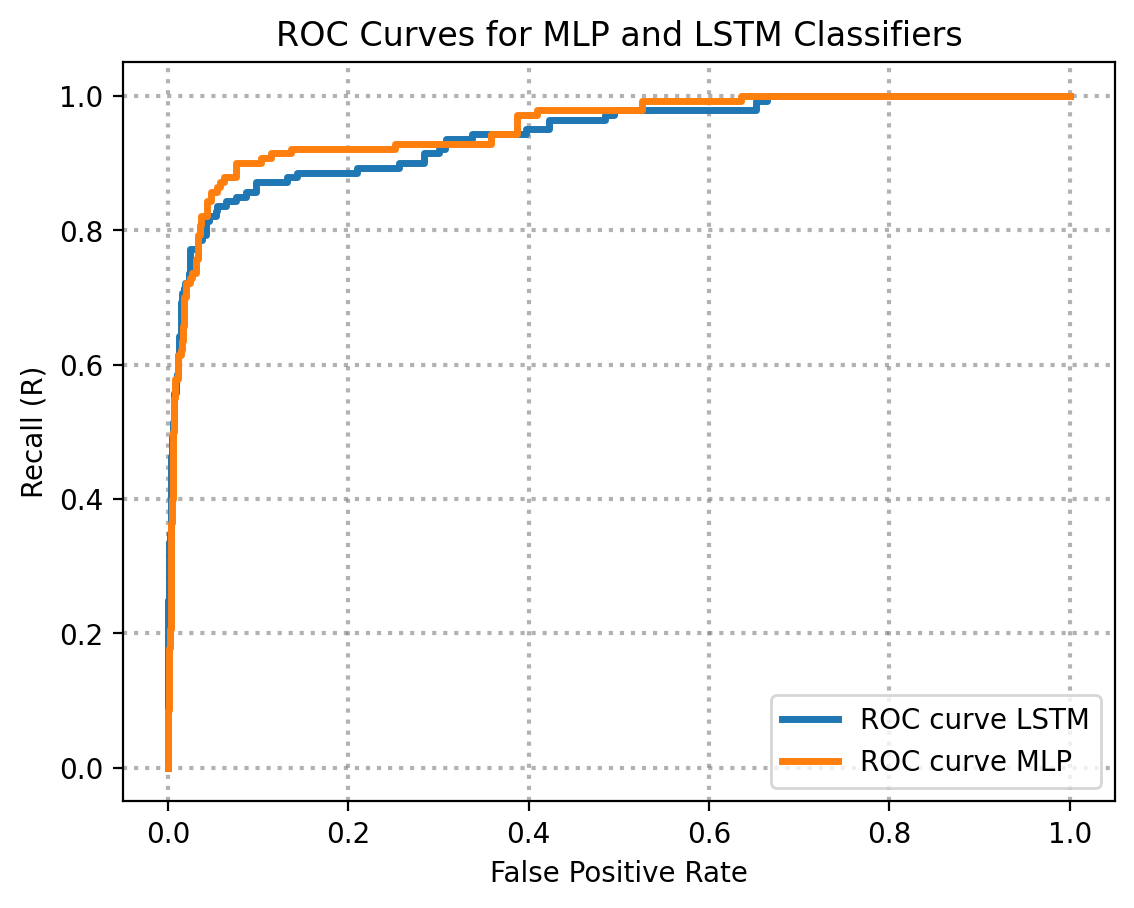

AUC ROC for LSTM is 0.9416974957313602
AUC ROC for MLP is 0.9526678998292544


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

def compute_mean_embedding(doc, length):
    # Extracting vectors of valid tokens excluding junk tokens
    valid_tokens = [token.vector for i, token in enumerate(doc) if i < length]

    if valid_tokens:
        # If the token is valid, compute the mean of the vectors
        return np.mean(valid_tokens, axis=0)
    else:
        # If no valid tokens, return an array of zeros
        return np.zeros_like(doc[0].vector)

# compute the means for train and test
mean_embeddings_train = np.array([compute_mean_embedding(doc, length) for doc, length in zip(docs_train, train_lengths)])
mean_embeddings_test = np.array([compute_mean_embedding(doc, length) for doc, length in zip(docs_test, test_lengths)])

# create the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=0)
mlp_classifier.fit(mean_embeddings_train, y_train)

# compute the measures of the created MLP
mlp_accuracy = mlp_classifier.score(mean_embeddings_test, y_test)
mlp_probs = mlp_classifier.predict_proba(mean_embeddings_test)

# ROC curve and AUC for MLP
fpr_mlp, recall_mlp, thresholds_mlp = metrics.roc_curve(y_test, mlp_probs[:, 1], pos_label=1)
area_roc_mlp = metrics.roc_auc_score(y_test, mlp_probs[:, 1])

# Plot ROC curve for both MLP and LSTM
fig, ax = plt.subplots()
plt.plot(fpr, recall, lw=2.5, label='ROC curve LSTM')
plt.plot(fpr_mlp, recall_mlp, lw=2.5, label='ROC curve MLP')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('ROC Curves for MLP and LSTM Classifiers')
plt.grid(True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.show()

print(f"AUC ROC for LSTM is {area_roc_LSTM}")
print(f"AUC ROC for MLP is {area_roc_mlp}")